# Models

Three models.

1. travel time ~ travel distance + road attributes. [i,j]
2. mobility flow ~ origin attributes + destination attributes + travel time
3. income ~ mobility flow (aggregate for origin or destination, or not?)


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot
import pickle
import geoplot.crs as gcrs
import statsmodels.api as sm

In [15]:
# read two datasets
edge_df = pd.read_pickle('../../data_process/edge_specific_df.pickle')
node_df = pd.read_pickle('../../data_process/node_specific_df.pickle')
node_degree_df = pd.read_pickle('../../data_process/node_degree_df.pickle')
edge_degree_df = pd.read_pickle('../../data_process/edge_degree_df.pickle')

In [16]:
print(edge_df.shape)
print(node_df.shape)
print(edge_degree_df.shape)
print(edge_df.columns)
print(node_df.columns)
print(edge_degree_df.columns)
print(node_degree_df.columns)

(10240, 27)
(103, 42)
(10240, 39)
Index(['timestamp', 'destination', 'state', 'origin', 'unique_agents',
       'sum_stay_duration', 'total_stays', 'OD', 'class_ART', 'class_BUS',
       'class_COLL', 'class_FREE', 'class_HWY', 'class_LOCL', 'class_SUBA',
       'class_TRK2', 'class_TRK4', 'class_UND', 'num_jobs_000_persons_origin',
       'sa2_code16_x', 'median_income_per_job_aud_origin',
       'num_jobs_000_persons_destination', 'sa2_code16_y',
       'median_income_per_job_aud_destination', 'od_duration_value',
       'od_distance_value', 'road_counts'],
      dtype='object')
Index(['SA2_MAIN16', 'SA2_5DIG16', 'SA2_NAME16', 'SA3_CODE16', 'SA3_NAME16',
       'SA4_CODE16', 'SA4_NAME16', 'GCC_CODE16', 'GCC_NAME16', 'STE_CODE16',
       'STE_NAME16', 'AREASQKM16', 'class_ART', 'class_BUS', 'class_COLL',
       'class_FREE', 'class_HWY', 'class_LOCL', 'class_SUBA', 'class_TRK2',
       'class_TRK4', 'class_UND', 'geometry', 'num_jobs_000_persons',
       'sa2_code16', 'median_income_p

In [17]:
edge_degree_df.head()

,timestamp,destination,state,origin,unique_agents,sum_stay_duration,total_stays,OD,class_ART,class_BUS,...,num_2degree_x,num_3degree_x,num_4degree_x,num_greater5degree_x,num_nodes_y,num_1degree_y,num_2degree_y,num_3degree_y,num_4degree_y,num_greater5degree_y
0,2018-02-01T00:00:00.000+11:00,401011001,4,401011001,19863,268779414,681217,401011001401011001,208.0,13.0,...,199.0,865.0,276.0,11.0,1642.0,291.0,199.0,865.0,276.0,11.0
1,2018-02-01T00:00:00.000+11:00,401011002,4,401011001,6911,4857456,29322,401011001401011002,267.0,16.0,...,199.0,865.0,276.0,11.0,517.0,149.0,54.0,239.0,69.0,6.0
2,2018-02-01T00:00:00.000+11:00,401021003,4,401011001,404,253764,1334,401011001401021003,838.0,82.0,...,199.0,865.0,276.0,11.0,4034.0,1174.0,731.0,1982.0,141.0,6.0
3,2018-02-01T00:00:00.000+11:00,401021004,4,401011001,1184,903377,5487,401011001401021004,430.0,13.0,...,199.0,865.0,276.0,11.0,2455.0,710.0,502.0,1126.0,110.0,7.0
4,2018-02-01T00:00:00.000+11:00,401021005,4,401011001,700,189721,1278,401011001401021005,517.0,13.0,...,199.0,865.0,276.0,11.0,989.0,286.0,245.0,421.0,36.0,1.0


## Model 1 - Travel Time

In [18]:
def combination(nums, k):
    res = []
    nums.sort()
    def dfs(A, path):
        if len(path) == k:
            res.append(path[:])
            return
        #even faster, you can just do while A and popleft, rather than copying B, as for the dup check, just keep track of a prev
        for i, elt in enumerate(A):
            if i-1 >= 0 and elt == A[i-1]:
                continue
            path.append(elt)
            dfs(A[i+1:], path)
            path.pop()
    dfs(nums,[])
    return res

In [19]:
# edge_degree_df_vars = np.array(['od_distance_value',
#                              'class_ART', 
#                     'class_BUS', 'class_COLL', 'class_FREE', 'class_HWY', 'class_LOCL', 
#                              'class_SUBA', 'class_TRK2', 'class_TRK4', 'class_UND', 'num_nodes_x', 'num_1degree_x',
#        'num_2degree_x', 'num_3degree_x', 'num_4degree_x',
#        'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
#        'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y'])
# _max = len(edge_degree_df_vars)
# print(_max)
# indices = []
# temp = [i for i in range(0,_max)]
# for i in range(11,_max+1):
#     print(i)
#     poss = combination(temp, i)
#     for elt in poss:
#         indices.append(elt)


In [20]:
# print(indices)

In [21]:
# best = 0
# best_vars = None
# best_model = None
# print(len(indices))
# for i,index in enumerate(indices):
#     if i%1000==0: print(i)
#     curr_vars = edge_degree_df_vars[index]
#     # y
#     y = np.log(edge_degree_df['od_duration_value'])

#     # X
#     X = np.log(edge_degree_df[curr_vars])

#     X = sm.add_constant(X)

    
#     # linear reg
#     mod = sm.OLS(y, X)
#     res = mod.fit()
#     if res.rsquared > best:
#         best = res.rsquared
#         best_vars = curr_vars
#         best_model = res
#         print("New best RSQUARED:", best)
#         print("New best variables:", best_vars)
    

In [22]:
# print("Highest rsquared:", best)
# print("Vars used:", best_vars)
# print("Best model summary:", best_model.summary())
# print(best_model.rsquared)

In [23]:
edge_degree_df[['od_distance_value', 'class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4', 
                                                    'class_UND', 'num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y']].isnull().sum()

od_distance_value       0
class_ART               0
class_BUS               0
class_COLL              0
class_FREE              0
class_HWY               0
class_LOCL              0
class_SUBA              0
class_TRK2              0
class_TRK4              0
class_UND               0
num_nodes_x             0
num_1degree_x           0
num_2degree_x           0
num_3degree_x           0
num_4degree_x           0
num_greater5degree_x    0
num_nodes_y             0
num_1degree_y           0
num_2degree_y           0
num_3degree_y           0
num_4degree_y           0
num_greater5degree_y    0
dtype: int64

In [24]:
edge_degree_df[['num_greater5degree_x']] = edge_degree_df[['num_greater5degree_x']] + 1
edge_degree_df[['num_greater5degree_y']] = edge_degree_df[['num_greater5degree_y']] + 1
edge_degree_df.head()

,timestamp,destination,state,origin,unique_agents,sum_stay_duration,total_stays,OD,class_ART,class_BUS,...,num_2degree_x,num_3degree_x,num_4degree_x,num_greater5degree_x,num_nodes_y,num_1degree_y,num_2degree_y,num_3degree_y,num_4degree_y,num_greater5degree_y
0,2018-02-01T00:00:00.000+11:00,401011001,4,401011001,19863,268779414,681217,401011001401011001,208.0,13.0,...,199.0,865.0,276.0,12.0,1642.0,291.0,199.0,865.0,276.0,12.0
1,2018-02-01T00:00:00.000+11:00,401011002,4,401011001,6911,4857456,29322,401011001401011002,267.0,16.0,...,199.0,865.0,276.0,12.0,517.0,149.0,54.0,239.0,69.0,7.0
2,2018-02-01T00:00:00.000+11:00,401021003,4,401011001,404,253764,1334,401011001401021003,838.0,82.0,...,199.0,865.0,276.0,12.0,4034.0,1174.0,731.0,1982.0,141.0,7.0
3,2018-02-01T00:00:00.000+11:00,401021004,4,401011001,1184,903377,5487,401011001401021004,430.0,13.0,...,199.0,865.0,276.0,12.0,2455.0,710.0,502.0,1126.0,110.0,8.0
4,2018-02-01T00:00:00.000+11:00,401021005,4,401011001,700,189721,1278,401011001401021005,517.0,13.0,...,199.0,865.0,276.0,12.0,989.0,286.0,245.0,421.0,36.0,2.0


In [25]:
# y
y = np.log(edge_degree_df['od_duration_value'])
#This uses all variables!
# X
X_all = np.log(edge_degree_df[['od_distance_value', 'class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4',  
                                                    'class_UND', "road_counts",
                                                    'num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y']])

X_all = sm.add_constant(X_all)

#od_distance
X_od_distance = np.log(edge_degree_df[['od_distance_value']])

X_od_distance = sm.add_constant(X_od_distance)

#od_distance + class
X_od_distance_class = np.log(edge_degree_df[['od_distance_value','class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4',  
                                                    'class_UND', "road_counts"]])

X_od_distance_class = sm.add_constant(X_od_distance_class)


#od_distance + node counts
X_od_distance_node = np.log(edge_degree_df[['od_distance_value','num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y']])

X_od_distance_node = sm.add_constant(X_od_distance_node)



In [26]:
r_squared_list = []
variables = ["ALL", "od_distance", "od_distance + class", "od_distance + node counts"]
models = []

# linear reg
print("==============================================================================")
print("Variables: ALL")
mod = sm.OLS(y, X_all)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

print("==============================================================================")
print("Variables: od_distance")
mod = sm.OLS(y, X_od_distance)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

print("==============================================================================")
print("Variables: od_distance + class")
mod = sm.OLS(y, X_od_distance_class)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

print("==============================================================================")
print("Variables: od_distance + node counts")
mod = sm.OLS(y, X_od_distance_node)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

data = [X_all, X_od_distance, X_od_distance_class, X_od_distance_node]

models = list(zip(variables,data,models))

Variables: ALL
                            OLS Regression Results                            
Dep. Variable:      od_duration_value   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.875e+04
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:13:00   Log-Likelihood:                 8018.0
No. Observations:               10240   AIC:                        -1.599e+04
Df Residuals:                   10215   BIC:                        -1.581e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const            

In [27]:
for i in range(4):
    print(variables[i], ":", r_squared_list[i])

ALL : 0.9854109153851104
od_distance : 0.9725200017889424
od_distance + class : 0.9848582829486681
od_distance + node counts : 0.9734734964447262


ALL


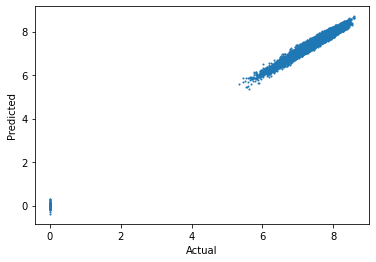

od_distance


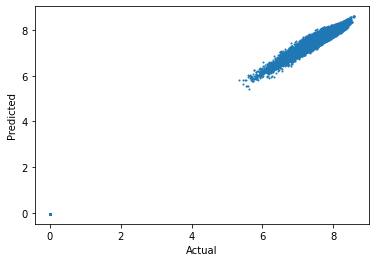

od_distance + class


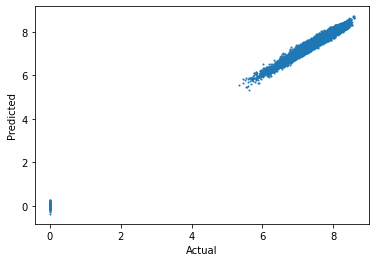

od_distance + node counts


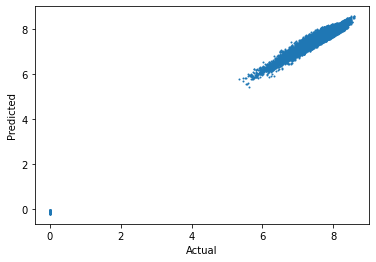

In [28]:
for variables,data, model in models:
    print(variables)
    y_pred = model.predict(data)
    plt.clf()
    plt.scatter(y,y_pred,s=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

In [29]:
all_vars = ['Constant','od_distance_value', 'class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4',  
                                                    'class_UND', "road_counts",
                                                    'num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y', 'Observations',
                                                   'R_squared', 'Adjusted_R_squared']
errors = []
for elt in all_vars:
    e = elt + "_err"
    errors.append(e)
temp = []
for i in range(len(all_vars)):
    temp.append(all_vars[i])
    if all_vars[i] not in {'Observations','R_squared', 'Adjusted_R_squared'}:
        temp.append(errors[i])

print(all_vars)
print(temp)

['Constant', 'od_distance_value', 'class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 'class_HWY', 'class_LOCL', 'class_SUBA', 'class_TRK2', 'class_TRK4', 'class_UND', 'road_counts', 'num_nodes_x', 'num_1degree_x', 'num_2degree_x', 'num_3degree_x', 'num_4degree_x', 'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y', 'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y', 'Observations', 'R_squared', 'Adjusted_R_squared']
['Constant', 'Constant_err', 'od_distance_value', 'od_distance_value_err', 'class_ART', 'class_ART_err', 'class_BUS', 'class_BUS_err', 'class_COLL', 'class_COLL_err', 'class_FREE', 'class_FREE_err', 'class_HWY', 'class_HWY_err', 'class_LOCL', 'class_LOCL_err', 'class_SUBA', 'class_SUBA_err', 'class_TRK2', 'class_TRK2_err', 'class_TRK4', 'class_TRK4_err', 'class_UND', 'class_UND_err', 'road_counts', 'road_counts_err', 'num_nodes_x', 'num_nodes_x_err', 'num_1degree_x', 'num_1degree_x_err', 'num_2degree_x', 'num_2degree_x_err', 'num_3degree_x', 'n

In [30]:
table1 = pd.DataFrame(columns=temp)
for variables,data, model in models:
    dict = {}
    for i, elt in enumerate(all_vars):
        if elt in model.params:
            i = list(model.params.keys()).index(elt)
            pval = model.pvalues[i]
            tag = ""
            if pval < 0.001:
                tag = "***"
            elif pval < 0.01:
                tag = "**"
            elif pval < 0.05:
                tag = "*"
            dict[elt] = str(round(model.params[elt], 3)) + tag
            dict[elt+"_err"] = "(" + str(round(model.bse[elt], 3)) + ")"
        else:
            dict[elt] = "" 
            if elt not in {'Observations', 'R_squared', 'Adjusted_R_squared'}:
                dict[elt+"_err"] = ""
    dict["Observations"] = model.nobs
    dict["R_squared"] = round(model.rsquared,3)
    dict["Adjusted_R_squared"] = round(model.rsquared_adj,3)
    i = list(model.params.keys()).index("const")
    pval = model.pvalues[i]
    tag = ""
    if pval < 0.001:
        tag = "***"
    elif pval < 0.01:
        tag = "**"
    elif pval < 0.05:
        tag = "*"
    dict["Constant"] = str(round(model.params["const"],3)) + tag
    dict["Constant_err"] = "(" + str(round(model.bse["const"], 3)) + ")"
    
    table1 = table1.append(dict, ignore_index=True)

In [31]:
table1.head(5)

,Constant,Constant_err,od_distance_value,od_distance_value_err,class_ART,class_ART_err,class_BUS,class_BUS_err,class_COLL,class_COLL_err,...,num_2degree_y_err,num_3degree_y,num_3degree_y_err,num_4degree_y,num_4degree_y_err,num_greater5degree_y,num_greater5degree_y_err,Observations,R_squared,Adjusted_R_squared
0,-0.143*,(0.069),0.719***,(0.001),0.031***,(0.002),0.022***,(0.001),0.137***,(0.006),...,(0.005),0.104***,(0.018),-0.015***,(0.003),0.004*,(0.002),10240.0,0.985,0.985
1,-0.05***,(0.013),0.751***,(0.001),,,,,,,...,,,,,,,,10240.0,0.973,0.973
2,-0.451***,(0.039),0.72***,(0.001),0.024***,(0.002),0.023***,(0.001),0.141***,(0.006),...,,,,,,,,10240.0,0.985,0.985
3,-0.088,(0.083),0.756***,(0.001),,,,,,,...,(0.007),0.022,(0.024),0.009*,(0.004),-0.002,(0.003),10240.0,0.973,0.973


In [32]:
table1.T.head(100)

,0,1,2,3
Constant,-0.143*,-0.05***,-0.451***,-0.088
Constant_err,(0.069),(0.013),(0.039),(0.083)
od_distance_value,0.719***,0.751***,0.72***,0.756***
od_distance_value_err,(0.001),(0.001),(0.001),(0.001)
class_ART,0.031***,,0.024***,
class_ART_err,(0.002),,(0.002),
class_BUS,0.022***,,0.023***,
class_BUS_err,(0.001),,(0.001),
class_COLL,0.137***,,0.141***,
class_COLL_err,(0.006),,(0.006),


In [33]:
print(table1.T.to_latex())

\begin{tabular}{lllll}
\toprule
{} &          0 &         1 &          2 &          3 \\
\midrule
Constant                 &    -0.143* &  -0.05*** &  -0.451*** &     -0.088 \\
Constant\_err             &    (0.069) &   (0.013) &    (0.039) &    (0.083) \\
od\_distance\_value        &   0.719*** &  0.751*** &    0.72*** &   0.756*** \\
od\_distance\_value\_err    &    (0.001) &   (0.001) &    (0.001) &    (0.001) \\
class\_ART                &   0.031*** &           &   0.024*** &            \\
class\_ART\_err            &    (0.002) &           &    (0.002) &            \\
class\_BUS                &   0.022*** &           &   0.023*** &            \\
class\_BUS\_err            &    (0.001) &           &    (0.001) &            \\
class\_COLL               &   0.137*** &           &   0.141*** &            \\
class\_COLL\_err           &    (0.006) &           &    (0.006) &            \\
class\_FREE               &  -0.008*** &           &  -0.007*** &            \\
class\_FREE\_err 

## Model 2 - Mobility Flow 

Gravity model:
$$ T_{ij} = \frac{T_i^{\alpha} T_j^{\beta}}{C_{ij}^{\gamma}}$$

Log-linear form:
$$ \log T_{ij} = \alpha \log T_i + \beta \log T_j - \gamma \log C_{ij} $$

Let us use basic economic info here.
1. $T_{ij}$ is the mobility flow from i to j.
2. $T_i$ and $T_j$ represent attractions, e.g. number of total jobs.
3. $C_{ij}$ represents frictions, e.g. travel time or other road attributes. Ideally, $C_{ij}$ can represent the actionable variables, such as road capacity/types. 

OLS can be used to estimate the three parameters $\alpha$, $\beta$, and $\gamma$.

More generally, we can write the gravity model as:
$$ \log T_{ij} = f_1(\log T_i, \log T_j; w_1) + f_2(\log C_{ij}; w_2) $$


In [34]:
edge_df_vars = np.array(['num_jobs_000_persons_origin', 'num_jobs_000_persons_destination',
                    'od_duration_value'])
_max = len(edge_df_vars)
print(_max)
indices = []
temp = [i for i in range(0,_max)]
for i in range(1,_max+1):
    poss = combination(temp, i)
    for elt in poss:
        indices.append(elt)
print(indices)

3
[[0], [1], [2], [0, 1], [0, 2], [1, 2], [0, 1, 2]]


In [35]:
best = 0
best_vars = None
best_model = None
for index in indices:
    curr_vars = edge_df_vars[index]
    print(curr_vars)
    # y
    y = np.log(edge_df['total_stays'])

    # X
    X = np.log(edge_df[curr_vars])

    X = sm.add_constant(X)

    
    # linear reg
    mod = sm.OLS(y, X)
    res = mod.fit()
    if res.rsquared > best:
        best = res.rsquared
        best_vars = curr_vars
        best_model = res
        print("New best RSQUARED:", best)
    
    print(res.rsquared)

['num_jobs_000_persons_origin']
New best RSQUARED: 0.061052503714691286
0.061052503714691286
['num_jobs_000_persons_destination']
New best RSQUARED: 0.06242015918604127
0.06242015918604127
['od_duration_value']
New best RSQUARED: 0.48081332898550966
0.48081332898550966
['num_jobs_000_persons_origin' 'num_jobs_000_persons_destination']
0.12796150814389184
['num_jobs_000_persons_origin' 'od_duration_value']
New best RSQUARED: 0.528833003375121
0.528833003375121
['num_jobs_000_persons_destination' 'od_duration_value']
0.5277485412246488
['num_jobs_000_persons_origin' 'num_jobs_000_persons_destination'
 'od_duration_value']
New best RSQUARED: 0.5794278271715446
0.5794278271715446


In [36]:
print("Highest rsquared:", best)
print("Vars used:", best_vars)
print("Best model summary:", best_model.summary())

Highest rsquared: 0.5794278271715446
Vars used: ['num_jobs_000_persons_origin' 'num_jobs_000_persons_destination'
 'od_duration_value']
Best model summary:                             OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4701.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:13:02   Log-Likelihood:                -15019.
No. Observations:               10240   AIC:                         3.005e+04
Df Residuals:                   10236   BIC:                         3.008e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err

In [37]:
# y
y = np.log(edge_df['total_stays'])
# y = np.log(edge_df['unique_agents'])

# X
X = np.log(edge_df[['num_jobs_000_persons_origin', 'num_jobs_000_persons_destination',
                    'od_duration_value']])

X = sm.add_constant(X)


In [38]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
print(res.rsquared)

                            OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4701.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:13:03   Log-Likelihood:                -15019.
No. Observations:               10240   AIC:                         3.005e+04
Df Residuals:                   10236   BIC:                         3.008e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [39]:
all_vars = ['Constant','num_jobs_000_persons_origin', 'num_jobs_000_persons_destination', 'od_duration_value']
errors = []
for elt in all_vars:
    e = elt + "_err"
    errors.append(e)
temp = []
for i in range(len(all_vars)):
    temp.append(all_vars[i])
    if all_vars[i] not in {'Observations','R_squared', 'Adjusted_R_squared'}:
        temp.append(errors[i])

print(all_vars)
print(temp)

['Constant', 'num_jobs_000_persons_origin', 'num_jobs_000_persons_destination', 'od_duration_value']
['Constant', 'Constant_err', 'num_jobs_000_persons_origin', 'num_jobs_000_persons_origin_err', 'num_jobs_000_persons_destination', 'num_jobs_000_persons_destination_err', 'od_duration_value', 'od_duration_value_err']


In [40]:
table1 = pd.DataFrame(columns=temp)
models = [("All",X,res)]
for variables,data, model in models:
    dict = {}
    for i, elt in enumerate(all_vars):
        if elt in model.params:
            i = list(model.params.keys()).index(elt)
            pval = model.pvalues[i]
            tag = ""
            if pval < 0.001:
                tag = "***"
            elif pval < 0.01:
                tag = "**"
            elif pval < 0.05:
                tag = "*"
            dict[elt] = str(round(model.params[elt], 3)) + tag
            dict[elt+"_err"] = "(" + str(round(model.bse[elt], 3)) + ")"
        else:
            dict[elt] = "" 
            if elt not in {'Observations', 'R_squared', 'Adjusted_R_squared'}:
                dict[elt+"_err"] = ""
    dict["Observations"] = model.nobs
    dict["R_squared"] = round(model.rsquared,3)
    dict["Adjusted_R_squared"] = round(model.rsquared_adj,3)
    i = list(model.params.keys()).index("const")
    pval = model.pvalues[i]
    tag = ""
    if pval < 0.001:
        tag = "***"
    elif pval < 0.01:
        tag = "**"
    elif pval < 0.05:
        tag = "*"
    dict["Constant"] = str(round(model.params["const"],3)) + tag
    dict["Constant_err"] = "(" + str(round(model.bse["const"], 3)) + ")"
    
    table1 = table1.append(dict, ignore_index=True)

In [41]:
table1.head()

,Constant,Constant_err,num_jobs_000_persons_origin,num_jobs_000_persons_origin_err,num_jobs_000_persons_destination,num_jobs_000_persons_destination_err,od_duration_value,od_duration_value_err,Adjusted_R_squared,Observations,R_squared
0,13.276***,(0.105),0.755***,(0.021),0.56***,(0.016),-1.189***,(0.011),0.579,10240.0,0.579


In [42]:
table1.T.head(100)

,0
Constant,13.276***
Constant_err,(0.105)
num_jobs_000_persons_origin,0.755***
num_jobs_000_persons_origin_err,(0.021)
num_jobs_000_persons_destination,0.56***
num_jobs_000_persons_destination_err,(0.016)
od_duration_value,-1.189***
od_duration_value_err,(0.011)
Adjusted_R_squared,0.579
Observations,10240.0


In [43]:
print(table1.T.to_latex())

\begin{tabular}{ll}
\toprule
{} &          0 \\
\midrule
Constant                             &  13.276*** \\
Constant\_err                         &    (0.105) \\
num\_jobs\_000\_persons\_origin          &   0.755*** \\
num\_jobs\_000\_persons\_origin\_err      &    (0.021) \\
num\_jobs\_000\_persons\_destination     &    0.56*** \\
num\_jobs\_000\_persons\_destination\_err &    (0.016) \\
od\_duration\_value                    &  -1.189*** \\
od\_duration\_value\_err                &    (0.011) \\
Adjusted\_R\_squared                   &      0.579 \\
Observations                         &    10240.0 \\
R\_squared                            &      0.579 \\
\bottomrule
\end{tabular}



All


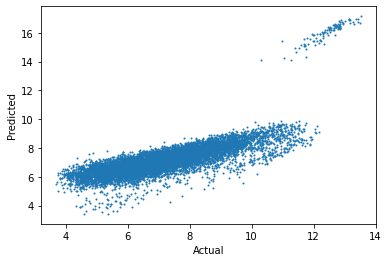

In [44]:
for variables,data, model in models:
    print(variables)
    y_pred = model.predict(data)
    plt.clf()
    plt.scatter(y,y_pred,s=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

## Model 3 - Economic Growth

In [45]:
print(node_df.columns)

Index(['SA2_MAIN16', 'SA2_5DIG16', 'SA2_NAME16', 'SA3_CODE16', 'SA3_NAME16',
       'SA4_CODE16', 'SA4_NAME16', 'GCC_CODE16', 'GCC_NAME16', 'STE_CODE16',
       'STE_NAME16', 'AREASQKM16', 'class_ART', 'class_BUS', 'class_COLL',
       'class_FREE', 'class_HWY', 'class_LOCL', 'class_SUBA', 'class_TRK2',
       'class_TRK4', 'class_UND', 'geometry', 'num_jobs_000_persons',
       'sa2_code16', 'median_income_per_job_aud_persons', 'origin_x',
       'unique_agents_origin_counts', 'sum_stay_duration_origin_counts',
       'total_stays_origin_counts', 'destination_x',
       'unique_agents_destination_counts',
       'sum_stay_duration_destination_counts',
       'total_stays_destination_counts', 'origin_y',
       'unique_agents_origin_entropy', 'sum_stay_duration_origin_entropy',
       'total_stays_origin_entropy', 'destination_y',
       'unique_agents_destination_entropy',
       'sum_stay_duration_destination_entropy',
       'total_stays_destination_entropy'],
      dtype='object')


In [46]:
# var list
# var_list = ['unique_agents_origin_counts', 'unique_agents_destination_counts',
#             'unique_agents_origin_entropy', 'unique_agents_destination_entropy']

# var_list = ['sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
#             'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy']

var_list = ['total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy']


In [47]:
# y
y = np.log(node_df['median_income_per_job_aud_persons'])

# X
X = np.log(node_df[var_list])

X = sm.add_constant(X)


In [48]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                                    OLS Regression Results                                   
Dep. Variable:     median_income_per_job_aud_persons   R-squared:                       0.441
Model:                                           OLS   Adj. R-squared:                  0.419
Method:                                Least Squares   F-statistic:                     19.35
Date:                               Wed, 31 Mar 2021   Prob (F-statistic):           9.25e-12
Time:                                       21:13:05   Log-Likelihood:                 105.08
No. Observations:                                103   AIC:                            -200.2
Df Residuals:                                     98   BIC:                            -187.0
Df Model:                                          4                                         
Covariance Type:                           nonrobust                                         
                                      coef    std err       

In [49]:
# var list
var_list = ['unique_agents_origin_counts', 'unique_agents_destination_counts',
            'unique_agents_origin_entropy', 'unique_agents_destination_entropy',
            'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
            'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy',
            'total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy']


In [50]:
var_list = np.array(['unique_agents_origin_counts', 'unique_agents_destination_counts',
            'unique_agents_origin_entropy', 'unique_agents_destination_entropy',
            'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
            'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy',
            'total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy'])
_max = len(var_list)
print(_max)
indices = []
temp = [i for i in range(0,_max)]
for i in range(1,_max+1):
    poss = combination(temp, i)
    for elt in poss:
        indices.append(elt)
print(indices)

12
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 1, 5], [0, 1, 6], [0, 1, 7], [0, 1, 8], [0, 1, 9], [0, 1, 10], [0, 1, 11], [0, 2, 3], [0, 2, 4], [0, 2, 5], [0, 2, 6], [0, 2, 7], [0, 2, 8], [0, 2, 9], [0, 2, 10], [0, 2, 11], [0, 3, 4], [0, 3, 5], [0, 3, 6], [0, 3, 7], [0, 3, 8], [0, 3, 9], [0, 3, 10], [0, 3, 11], [0, 4, 5], [0, 4, 6], [0, 4, 7], [0, 4, 8], [0, 4, 9], [0, 4, 10], [0, 4, 11], [0

In [51]:
best = 0
best_vars = None
best_model = None
for index in indices:
    curr_vars = var_list[index]
    print(curr_vars)
    # y
    y = np.log(node_df['median_income_per_job_aud_persons'])

    # X
    X = np.log(node_df[curr_vars])

    X = sm.add_constant(X)

    
    # linear reg
    mod = sm.OLS(y, X)
    res = mod.fit()
    if res.rsquared > best:
        best = res.rsquared
        best_vars = curr_vars
        best_model = res
        print("New best RSQUARED:", best)
    
    print(res.rsquared)

['unique_agents_origin_counts']
New best RSQUARED: 0.015074885363259627
0.015074885363259627
['unique_agents_destination_counts']
New best RSQUARED: 0.10887612723044149
0.10887612723044149
['unique_agents_origin_entropy']
0.014813846296319433
['unique_agents_destination_entropy']
New best RSQUARED: 0.16995274736120636
0.16995274736120636
['sum_stay_duration_origin_counts']
0.0010601645233210277
['sum_stay_duration_destination_counts']
0.02893996424037537
['sum_stay_duration_origin_entropy']
0.02685154737262685
['sum_stay_duration_destination_entropy']
New best RSQUARED: 0.1806357848584873
0.1806357848584873
['total_stays_origin_counts']
0.0007395775937001359
['total_stays_destination_counts']
0.1044489391624156
['total_stays_origin_entropy']
0.10581935920227126
['total_stays_destination_entropy']
0.17142701096370094
['unique_agents_origin_counts' 'unique_agents_destination_counts']
New best RSQUARED: 0.3533303260707914
0.3533303260707914
['unique_agents_origin_counts' 'unique_agents_or

0.25452133273553523
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy']
0.26301149275493796
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'total_stays_origin_counts']
0.3718424345199307
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'total_stays_destination_counts']
0.4568120758052806
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'total_stays_origin_entropy']
0.3082997656467886
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'total_stays_destination_entropy']
0.24205138346785415
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts']
0.3828842521548623
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy']
0.20594764854084024
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy']
0.40238508303724496


0.22989189624061224
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.3869804176887378
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
0.03194907305474104
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts']
0.17270993871032014
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy']
0.1746681744168832
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_entropy']
0.33867343490309176
['unique_agents_origin_entropy' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts']
0.21875268038198925
['unique_agents_origin_entropy' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts']
0.2671696121402596
['unique_agents_origin_entropy' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_entropy']
0.4192391752753992
['u

0.42088030671793886
['sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.2031978322200806
['sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.42526894571449614
['total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4145415030257622
['total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.3861047186479828
['total_stays_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4127901011017402
['total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4123444631337362
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy']
0.36533432730363524
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_du

0.36060187823987977
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_destination_entropy']
0.3992992597701096
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy']
0.4549178077097705
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy']
0.451401418789367
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts']
0.46558480987937545
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts']
0.4622454114800343
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_entropy']
0.4475341481267594
['unique_agents_origin_

0.41298536702277466
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_destination_entropy']
0.3211752183274612
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy']
0.30209028547537287
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy']
0.23615877796130413
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts']
0.3192080537008125
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts']
0.351765097193521
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_entropy']
0.354135385250955
['unique_agents_destina

0.32471089397678965
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.3694162338904917
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4149497886822504
['unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.3865190442154337
['unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4303996105443342
['unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.2730007515649463
['unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4208810809975727
['unique_agents_destination_coun

0.40992539504890735
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.41926168670080444
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.2232991904094267
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.4128314752071611
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.10803860527533182
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.23425039648513468
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4145076320642114
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'to

0.39306236569130637
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.40799684613965403
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.33609907365341884
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.33320009559682007
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.3373012786766685
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.3329470908641633
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4163954175718205
['unique_agents_destination_entropy'
 'sum_stay

0.40546195403332286
['sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4209281151836114
['sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.38463878227488923
['sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.42213515322992434
['sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.38436799781685427
['sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.42539638789268086
['sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.43445406927604535
['sum_stay_duration_origin_

0.4546484277445946
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.452415928038575
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4330563319966222
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts']
0.45620117694779005
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy']
0.4322342127652681
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy']
0.43596435275485035
['unique_agents_origin_c

['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4477578829781682
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.436404827234956
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.47039726176701613
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4657432452726511
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.464894653365729
['unique_agents_origin_counts' 'unique_agents_destination_cou

0.46068857256293105
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy']
0.3054848410931541
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_entropy']
0.39847477735445025
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts']
0.45744420876964864
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts']
0.46095746807720595
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_entropy']
0.44816655496097435
['unique_agents_origin_counts' 'unique_agen

0.45800297539388
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy']
0.4697929816171389
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy']
0.4616548903487778
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts']
0.4667462075814468
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_destination_counts']
0.4695731189186705
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_entropy']
0.44858746233024327
['uniqu

0.4624408240111866
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.43950578587624745
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.4203357003809104
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.46518284508714747
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.28093427023901596
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.46025897574120245
['unique_agents_origin_counts' 'sum_stay_dur

0.4548629276391225
['unique_agents_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.45999379606078306
['unique_agents_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4610045606972184
['unique_agents_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4732776331130891
['unique_agents_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.44990517135915253
['unique_agents_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.45650356040614337
['unique_agents_origin_counts' 'total_stays_origin

0.375123538154691
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts']
0.31239269616340826
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts']
0.4122020205345389
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_entropy']
0.42731678259555905
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_entropy']
0.3215734032715861
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.41365374293814494
['unique_agents_des

0.41197404376464963
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4208452568507566
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.3300415210233363
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.37108605675268524
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.35092685943811464
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4197430431057726
['

0.4213973676371918
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.36732041102007995
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4254953437383945
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.40718722770033167
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4206939776352723
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.38874863382629576
['unique_agents_destina

0.4304211781639071
['unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4323007849168762
['unique_agents_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.44256416174164126
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy']
0.4059324665161067
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy']
0.40460457027376495
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts']
0.40905613858744583
['unique_a

0.41666776766950875
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4253173446484475
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.42687876632638433
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.3053786376935528
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4265526893095274
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.3181075078967007
['unique_agents_orig

0.4411877205804262
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.38754280940276065
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4128390179005835
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4216913305713639
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.38709352090498206
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.41428226249

0.384010921819956
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4177832713802152
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4028299623298871
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4462217780724467
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.3661055199865866
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.42642

0.4095410705459813
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.42351274316817045
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.3896115556948937
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4317453958488453
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4097470928993038
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.42547679415358874
['sum_st

0.4667024616353268
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_entropy']
0.457538671126803
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_entropy']
0.4529584107069301
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.4095091611604029
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts']
0.46443867593069454
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents

0.4534335534693238
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy']
0.4706826568396446
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_entropy']
0.43936551881440933
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.47877515265436577
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.45316821209563884
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'uniq

0.4379014845105058
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts']
0.47246531016758553
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts']
0.4904008937354526
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy']
0.45375449424276837
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_entropy']
0.43932910552270155
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_

0.45846719754742427
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.44241576490310364
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.478930393991147
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4750501429729448
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.46683987618286016
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 

0.48461513751609775
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.48422831676763667
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.4881879143569091
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.47018636310568696
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.45057912793763144
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_dura

0.4581218018045311
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.47212354861492456
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.42787124180978287
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.46388550207801293
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.47251290556749403
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_o

0.47057462443472187
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4615155953765936
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.45641638337804524
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.44123555868551967
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.44448666322335484
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay

0.4552473448790667
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4579739826056919
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4586759269563908
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4851071514311057
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4872997801893645
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_

0.438626905569798
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.48384363350607107
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.4702834765819913
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.4699387040256887
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.47539752354315234
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration

0.4697963798052853
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4625986501945134
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.461190903461253
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.44028492849334355
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.46686587701529514
['unique_agents_origin_counts' 'sum_stay_duration_origin_co

0.46928280044283455
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.48480028725310165
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.48989297155808875
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4609480019597748
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4874676473216779
['unique_agents_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duratio

0.3533967915821702
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.3846697386073291
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.3967017802000756
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.41983604118787554
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.3912443091606702
['unique_agents_destination_counts' 'unique_agents_origin_entropy

0.42189961431524625
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.3839785693861274
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.431732885112072
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4256320557790947
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.420874693818894
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_co

0.41161911177684085
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4304804481825951
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.43275770374369305
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.44423442740023
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.398367873120022
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_sta

0.41305385861903854
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.47452756174099275
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.351011749201926
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.3718198956098162
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.3916216830072138
['unique_agents_destination_counts' 'unique_agents_destinati

0.3885790842151231
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.43838945156426223
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.40724190985172104
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.45508041178124714
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.3904352409867803
['unique_agents_destination_counts' 'sum_stay_duration_

0.44335380133022073
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4440805495871374
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.40672459181770004
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.43055776848101457
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.432593891676587
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'to

0.4152629022144174
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.42665087412190816
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.4002209360861564
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.4296784160295656
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.47128811363648815
['unique_agents_origin_entropy' 'unique_agents_destination_ent

0.4134094799115188
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.43703289158967906
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.39369410179877307
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4362988384671993
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.41958322097862655
['unique_agents_origin_entropy' 'sum_stay_duration_origin_

0.44158431206930393
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4264793799364237
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.44281503597406136
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4424618668825224
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4146033598907748
['unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_des

0.4572294239249207
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.44220960482694427
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.40754056793028703
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4592537053038793
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.45412108749849034
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_st

0.4721340568195297
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.44480834249161894
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.4599570629218527
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
0.5028254221144666
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin

0.46705113118029395
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4640916180489235
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.44849301116239404
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
0.4849835088400003
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entro

0.4841017004347067
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4541385722371375
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4713786377402073
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.43941671659546744
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_st

0.4580124668198068
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4754237364179229
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.4707844515632321
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
New best RSQUARED: 0.5054720182853274
0.5054720182853274
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destinat

0.5048580066062603
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.47148101845171897
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.49828420668530027
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.46485682091905967
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_ori

0.4733540340186737
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.46637772479410755
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.47714980575463783
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4793905287921004
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stay

0.4748194984601092
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.470201324814182
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4620367334484542
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4757857330714482
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destina

0.5031731972535992
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.502336035480481
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.5028379432033425
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4928200715670453
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_s

0.4848936267534735
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4629470004370969
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4639683813388882
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4608766665103985
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_count

0.4775672557064844
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
New best RSQUARED: 0.5070375919935867
0.5070375919935867
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.48938825287244614
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.5016692423193747
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_count

0.5024333374835754
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4943081378646993
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.49494845052826886
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.48801761584504055
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin

0.45587985367969197
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_entropy']
0.4079667861211884
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.40911703710648784
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4351748617917812
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_co

0.39115044981496916
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4320292789525052
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4004449834931201
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4311168506816939
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts

0.422329746086785
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4324861515449743
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4024001058554817
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.43601560549587304
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_

0.388779628375745
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.45061119354501555
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.40893382605657647
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.45921498744752176
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_

0.43053715092200295
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4108579062114107
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.43184942792651804
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4754744559998707
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_coun

0.4455093583819588
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4504392582487651
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.41734972491776223
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4330814650731267
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum

0.4326473423794456
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.47158531270051784
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4193967848798621
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4501445038130658
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_

0.41561636996778517
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4724003204484146
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4035533580096856
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4525826088710122
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destinati

0.47388016924324194
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.4810653704768757
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.4966042589920451
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.4869979272892976
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_

0.4666268161348265
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4963152683525849
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.48713702416719895
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4963648470187356
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destin

0.471614561584612
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.467755870276094
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.459608213646044
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.47962186745031155
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_durati

0.4966766106988437
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.48827601237006746
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.47790013721590263
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.481127306580438
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'uniq

0.47176642406591107
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.46606533789542126
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.47908626337665583
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4790164607785403
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_st

0.4883906459541454
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4964306418215879
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4884268627374456
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.47549130661620453
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entr

0.47091477078685173
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4826497836897605
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.48270666342404944
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4734969765260578
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_de

0.4963268702073499
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.48227026447402177
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.49616220210690354
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4937029938856905
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 's

0.44336077221721826
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.43749828974747274
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4444302340795111
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4479693447575327
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entro

0.44187634618725624
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.42564861125904474
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4644945826971121
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.44994551919914505
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_dura

0.4408562022508854
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4663318514147854
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.45100689625860857
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4757711513865581
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destinat

0.42783224083012583
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.47176798568021905
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4514443635731653
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.45668026234308845
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_count

0.49401770276575263
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.47883340291704035
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.48002544774397493
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.492238109723817


0.46784587544155865
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.49146769387488376
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.48597434063425415
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.49018703654375606
['

0.494344520069118
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.49487443440570333
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.48166471844394965
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4937732865

0.4964374789334782
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.48229718455463155
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4965053572423417
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.49371201302873113
['unique

['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4749145092024962
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.41882832286045735
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4565102366

0.44682809109566546
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4543153033036983
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4698664082520383
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4774486049

0.48243234626791986
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4967272069876427
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4943561628883646
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_count

0.507723821131059
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.5001307329209319
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.5073828294964214
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_sta

0.5062188017377789
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4969948187422233
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4955096696825265
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_or

In [52]:
print("Highest rsquared:", best)
print("Vars used:", best_vars)
print("Best model summary:", best_model.summary())

Highest rsquared: 0.5083186248331018
Vars used: ['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
Best model summary:                                     OLS Regression Results                                   
Dep. Variable:     median_income_per_job_aud_persons   R-squared:                       0.508
Model:                                           OLS   Adj. R-squared:                  0.443
Method:                                Least Squares   F-statistic:                     7.754
Date:                               Wed, 31 Mar 2021   Prob (F-statistic):           1.07e-09
Time:                                       21:13:

In [53]:
# y
y = np.log(node_df['median_income_per_job_aud_persons'])

# X
X = np.log(node_df[var_list])

X = sm.add_constant(X)


In [54]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

print(res.rsquared)

                                    OLS Regression Results                                   
Dep. Variable:     median_income_per_job_aud_persons   R-squared:                       0.508
Model:                                           OLS   Adj. R-squared:                  0.443
Method:                                Least Squares   F-statistic:                     7.754
Date:                               Wed, 31 Mar 2021   Prob (F-statistic):           1.07e-09
Time:                                       21:13:26   Log-Likelihood:                 111.66
No. Observations:                                103   AIC:                            -197.3
Df Residuals:                                     90   BIC:                            -163.1
Df Model:                                         12                                         
Covariance Type:                           nonrobust                                         
                                            coef    std err 

In [55]:
all_vars = ['Constant','unique_agents_origin_counts', 'unique_agents_destination_counts',
            'unique_agents_origin_entropy', 'unique_agents_destination_entropy',
            'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
            'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy',
            'total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy']
errors = []
for elt in all_vars:
    e = elt + "_err"
    errors.append(e)
temp = []
for i in range(len(all_vars)):
    temp.append(all_vars[i])
    if all_vars[i] not in {'Observations','R_squared', 'Adjusted_R_squared'}:
        temp.append(errors[i])

print(all_vars)
print(temp)

['Constant', 'unique_agents_origin_counts', 'unique_agents_destination_counts', 'unique_agents_origin_entropy', 'unique_agents_destination_entropy', 'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts', 'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy', 'total_stays_origin_counts', 'total_stays_destination_counts', 'total_stays_origin_entropy', 'total_stays_destination_entropy']
['Constant', 'Constant_err', 'unique_agents_origin_counts', 'unique_agents_origin_counts_err', 'unique_agents_destination_counts', 'unique_agents_destination_counts_err', 'unique_agents_origin_entropy', 'unique_agents_origin_entropy_err', 'unique_agents_destination_entropy', 'unique_agents_destination_entropy_err', 'sum_stay_duration_origin_counts', 'sum_stay_duration_origin_counts_err', 'sum_stay_duration_destination_counts', 'sum_stay_duration_destination_counts_err', 'sum_stay_duration_origin_entropy', 'sum_stay_duration_origin_entropy_err', 'sum_stay_duration_d

In [56]:
table1 = pd.DataFrame(columns=temp)
models = [("All",X,res)]
for variables,data, model in models:
    dict = {}
    for i, elt in enumerate(all_vars):
        if elt in model.params:
            i = list(model.params.keys()).index(elt)
            pval = model.pvalues[i]
            tag = ""
            if pval < 0.001:
                tag = "***"
            elif pval < 0.01:
                tag = "**"
            elif pval < 0.05:
                tag = "*"
            dict[elt] = str(round(model.params[elt], 3)) + tag
            dict[elt+"_err"] = "(" + str(round(model.bse[elt], 3)) + ")"
        else:
            dict[elt] = "" 
            if elt not in {'Observations', 'R_squared', 'Adjusted_R_squared'}:
                dict[elt+"_err"] = ""
    dict["Observations"] = model.nobs
    dict["R_squared"] = round(model.rsquared,3)
    dict["Adjusted_R_squared"] = round(model.rsquared_adj,3)
    i = list(model.params.keys()).index("const")
    pval = model.pvalues[i]
    tag = ""
    if pval < 0.001:
        tag = "***"
    elif pval < 0.01:
        tag = "**"
    elif pval < 0.05:
        tag = "*"
    dict["Constant"] = str(round(model.params["const"],3)) + tag
    dict["Constant_err"] = "(" + str(round(model.bse["const"], 3)) + ")"
    
    table1 = table1.append(dict, ignore_index=True)

In [57]:
table1.T.head(100)

,0
Constant,13.658***
Constant_err,(1.641)
unique_agents_origin_counts,0.594*
unique_agents_origin_counts_err,(0.258)
unique_agents_destination_counts,0.031
unique_agents_destination_counts_err,(0.106)
unique_agents_origin_entropy,-0.089
unique_agents_origin_entropy_err,(0.611)
unique_agents_destination_entropy,-0.405
unique_agents_destination_entropy_err,(0.34)


In [58]:
print(table1.T.to_latex())

\begin{tabular}{ll}
\toprule
{} &          0 \\
\midrule
Constant                                  &  13.658*** \\
Constant\_err                              &    (1.641) \\
unique\_agents\_origin\_counts               &     0.594* \\
unique\_agents\_origin\_counts\_err           &    (0.258) \\
unique\_agents\_destination\_counts          &      0.031 \\
unique\_agents\_destination\_counts\_err      &    (0.106) \\
unique\_agents\_origin\_entropy              &     -0.089 \\
unique\_agents\_origin\_entropy\_err          &    (0.611) \\
unique\_agents\_destination\_entropy         &     -0.405 \\
unique\_agents\_destination\_entropy\_err     &     (0.34) \\
sum\_stay\_duration\_origin\_counts           &     -0.069 \\
sum\_stay\_duration\_origin\_counts\_err       &    (0.213) \\
sum\_stay\_duration\_destination\_counts      &     -0.272 \\
sum\_stay\_duration\_destination\_counts\_err  &    (0.178) \\
sum\_stay\_duration\_origin\_entropy          &     -0.418 \\
sum\_stay\_duration\_o

All


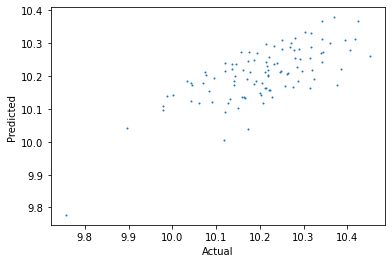

In [59]:
for variables,data, model in models:
    print(variables)
    y_pred = model.predict(data)
    plt.clf()
    plt.scatter(y,y_pred,s=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

In [60]:
node_df.shape

(103, 42)